In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCDPCN, Classifier, FCPCN
from pclib.nn.layers import DFC
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train_DeepiPC import train_iPC, val_pass, train_iPC_classifier

In [2]:
seed = 42
# For reproducibility
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

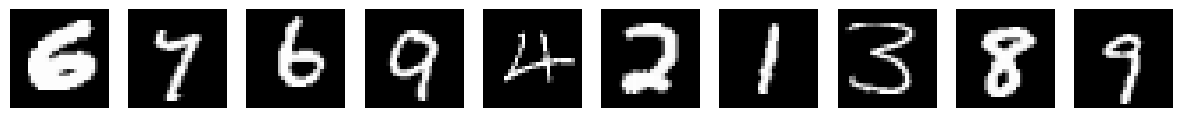

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

Initial VFE: 45.1286, Final VFE: 42.0816


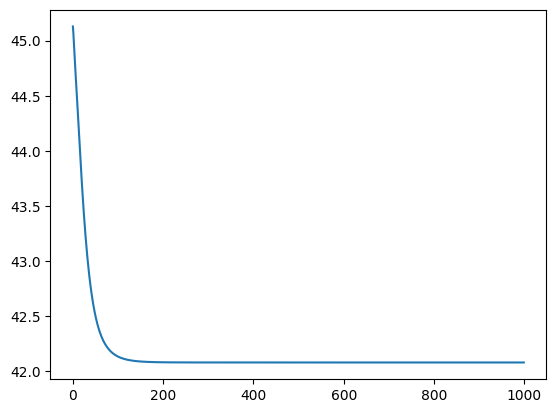

In [10]:
model = FCDPCN(
    # sizes=[INPUT_SHAPE, 1024, 512, 512],
    # precisions=[-9999, 4.0, 2.0, 7.0],
    sizes=[INPUT_SHAPE, 128],
    precisions=[1.0, 1.0],
    bias=True, 
    symmetric=True,
    actv_fn=F.relu,
    steps=250,
    gamma=0.001,
    x_decay=0.0,
    dropout=0.0,
    has_top=False,
).to(device)

x = train_dataset.transformed_images.flatten(1)
gamma = torch.ones(x.shape[0], device=device) * model.gamma
state, x_optimiser = model.init_state(x, pin_obs=True)

vfes = []
for _ in range(1000):
    model.step(state, x_optimiser, gamma)
    with torch.no_grad():
        vfes.append(model.vfe(state).item())

print(f'Initial VFE: {vfes[0]:.4f}, Final VFE: {vfes[-1]:.4f}')
plt.plot(vfes)

In [11]:
# torch.manual_seed(42)
model_name = "128"
NUM_EPOCHS = 2500
BATCH_SIZE = 48000
# log_dir = f'examples/mnist/out/logs/fc/unsup_iPC/x_decay/{model_name}'
log_dir=None
model_dir = None
train_iPC(
    model=model,
    supervised=False,
    train_data=train_dataset,
    val_data=val_dataset,
    num_epochs=NUM_EPOCHS,
    eval_every=250,
    lr=0.001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=True,
    neg_coeff=None,
    cd_coeff=None,
    cd_steps=1,
    log_dir=log_dir,
    model_dir=model_dir,
    minimal_stats=False,
    assert_grads=False,
    optim='AdamW',
    scheduler=None,
    no_momentum=False,
    norm_grads=False,
    norm_weights=False,
    learn_layer=None,
)
# train_iPC_classifier(
#     model,
#     classifier,
#     train_dataset,
#     val_dataset,
#     num_epochs=100,
#     lr=0.001,
#     batch_size=100,
#     reg_coeff=0.02,
#     flatten=True,
#     log_dir=log_dir,
#     optim='AdamW',
#     scheduler=None,
# )

KeyboardInterrupt: 

In [ ]:
cnn = nn.Sequential(
    nn.Unflatten(1, (128, 1, 1)),
    nn.ConvTranspose2d(128, 32, 7, stride=1),
    # nn.ConvTranspose2d(64, 32, 5, stride=2),
    nn.ConvTranspose2d(32, 32, 4, stride=4),
    # nn.ConvTranspose2d(32, 1, 4, stride=1),
).to(device)

z = torch.randn(10, 128).to(device)
cnn(z).shape


torch.Size([10, 32, 28, 28])

In [ ]:
x = val_dataset.transformed_images[:100].flatten(1)

_, state, _ = model(x, pin_obs=True)

# state, optimiser = model.init_state(x, pin_obs=True)
# gamma = torch.ones(x.shape[0], device=device) * model.gamma
# for _ in range(250):
#     model.step(state, optimiser, gamma)



vfe = model.vfe(state).item()
vfe



41.36286163330078

In [ ]:
mlp = torch.nn.Linear(10, 2)

state = {"x": torch.ones((1, 10), requires_grad=True)}
optimiser = torch.optim.SGD([state["x"]], lr=0.001)
x = torch.randn((1,2))

for _ in range(5):
    state_flatt = state["x"].flatten(1)
    pred = mlp(state_flatt)
    error = (x - pred).square().sum()
    optimiser.zero_grad()
    error.backward()
    optimiser.step()

In [ ]:
x = torch.randn(1, 784).to(device)
x.requires_grad = True
y = F.relu(x)
y.requires_grad

In [ ]:
x = torch.randn(1,1)
from torchviz import make_dot
make_dot(x).render('test', format="png")


In [ ]:
decays = [0.01, 0.05, 0.1, 0.5, 1.0]
for decay in decays:
    torch.manual_seed(seed)

    model_name = f'{decay}'
    model = FCPCN(
        sizes=[INPUT_SHAPE, 128],
        # precisions=[-9999, 4.0, 2.0, 7.0],
        precisions=[1.0, 1.0],
        bias=True, 
        symmetric=True,
        actv_fn=F.relu,
        steps=250,
        gamma=0.001,
        x_decay=decay,
        dropout=0.0,
        has_top=False,
    ).to(device)
    classifier = Classifier(128, 10).to(device)
    stats = {
        'epoch': 0,
        'posVfe': [],
        'negVfe': [],
        'negMse': [],
        'cdVfe': [],
        'valVfe': [],
        'valAcc': [],
    }

    NUM_EPOCHS = 2500
    BATCH_SIZE = 48000
    log_dir = f'examples/mnist/out/logs/fc/unsup_iPC/x_decay/{model_name}'
    # model_dir = f'examples/mnist/out/models/fc/unsup_iPC/layers/{model_name}'
    # log_dir = None
    model_dir = None
    train_iPC(
        model=model,
        supervised=False,
        train_data=train_dataset,
        val_data=val_dataset,
        num_epochs=NUM_EPOCHS,
        eval_every=250,
        lr=0.001,
        batch_size=BATCH_SIZE,
        reg_coeff=0.02,
        flatten=True,
        neg_coeff=None,
        cd_coeff=None,
        cd_steps=1,
        log_dir=log_dir,
        model_dir=model_dir,
        minimal_stats=False,
        assert_grads=False,
        optim='AdamW',
        scheduler=None,
        no_momentum=False,
        norm_grads=False,
        norm_weights=False,
        learn_layer=None,
    )

    train_iPC_classifier(
        model,
        classifier,
        train_dataset,
        val_dataset,
        num_epochs=100,
        lr=0.001,
        batch_size=100,
        reg_coeff=0.02,
        flatten=True,
        log_dir=log_dir,
        optim='AdamW',
        scheduler=None,
    )

In [ ]:
sizes_arr = [INPUT_SHAPE, 128], [INPUT_SHAPE, 128, 128], [INPUT_SHAPE, 128, 128, 128], [INPUT_SHAPE, 128, 128, 128, 128]]
for sizes in sizes_arr:
    torch.manual_seed(seed)

    model_name = f'{sizes}'
    model = FCPCN(
        # sizes=[INPUT_SHAPE, 1024, 512, 512],
        # precisions=[-9999, 4.0, 2.0, 7.0],
        sizes=sizes,
        precisions=[1.0 for _ in range(len(sizes))],
        bias=True, 
        symmetric=True,
        actv_fn=F.elu,
        steps=250,
        gamma=0.001,
        x_decay=0.0,
        dropout=0.0,
        has_top=False,
    ).to(device)
    # classifier = Classifier(model.sizes[-1], 10).to(device)
    
    stats = {
        'epoch': 0,
        'posVfe': [],
        'negVfe': [],
        'negMse': [],
        'cdVfe': [],
        'valVfe': [],
        'valAcc': [],
    }

    NUM_EPOCHS = 2500
    BATCH_SIZE = 48000
    log_dir = f'examples/mnist/out/logs/fc/unsup_iPC/layers/{model_name}'
    # model_dir = f'examples/mnist/out/models/fc/unsup_iPC/layers/{model_name}'
    # log_dir = None
    model_dir = None
    train_iPC(
        model=model,
        supervised=False,
        train_data=train_dataset,
        val_data=val_dataset,
        num_epochs=NUM_EPOCHS,
        eval_every=250,
        lr=0.001,
        batch_size=BATCH_SIZE,
        reg_coeff=0.02,
        flatten=True,
        neg_coeff=None,
        cd_coeff=None,
        cd_steps=1,
        log_dir=log_dir,
        model_dir=model_dir,
        minimal_stats=False,
        assert_grads=False,
        optim='AdamW',
        scheduler=None,
        no_momentum=False,
        norm_grads=False,
        norm_weights=False,
        learn_layer=None,
    )

    train_iPC_classifier(
        model,
        classifier,
        train_dataset,
        val_dataset,
        num_epochs=100,
        lr=0.001,
        batch_size=100,
        reg_coeff=0.02,
        flatten=True,
        log_dir=log_dir,
        optim='AdamW',
        scheduler=None,
    )

In [ ]:
x = torch.randn(100, 784).to(device)
out, _ = model(x)
out.norm()

In [ ]:
states = [torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=False)]
substates = [s for s in states if s.requires_grad]
len(substates)

In [ ]:
model.eval()
imgs = train_dataset.images.clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True, steps=200)
print(model.vfe(state))

sparsity = [(torch.abs(layer['x']) == 0).float().mean().item() for layer in state]
print(f'Sparsities: {sparsity}')

reconstructions = model.layers[1].predict(state[1])
mse = F.mse_loss(reconstructions, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].view(28, 28).detach().cpu(), cmap='gray')
    ax.axis('off')

In [ ]:
model.eval()
imgs = train_dataset.transformed_images.clone().flatten(1) + 0.3*torch.randn_like(train_dataset.transformed_images.clone().flatten(1))
state = model.init_state(imgs)

vfes = []
gamma = torch.ones(imgs.shape[0], device=device) * model.gamma
for _ in range(500):
    model.step(state, gamma=gamma, pin_obs=True)
    vfes.append(model.vfe(state).item())

plt.plot(vfes)

In [ ]:
model.eval()
imgs = train_dataset.transformed_images[:10].clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True, steps=2000)

out, state = model(y=out, pin_target=True, steps=500)
# out, state = model(imgs, y=out, steps=200)
reconstructions = state[0]['x']
mse = F.mse_loss(reconstructions, imgs)
print(mse)

# show first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(state[0]['x'][i].view(28, 28).detach().cpu(), cmap='gray')
    ax.axis('off')

In [ ]:
imgs = train_dataset.transformed_images.clone().flatten(1)
imgs.shape
out, state = model(imgs, pin_obs=True, steps=2000)
print('vfe: ', model.vfe(state).item())

mse = []
state = model.init_state(y=out)
gamma = torch.ones(state[0]['x'].shape[0], device=device) * model.gamma
prev_vfe = None
with torch.no_grad():
    for _ in range(2000):
        model.step(state, gamma, pin_target=True)
        reconstructions = state[0]['x']
        mse.append(F.mse_loss(reconstructions, imgs).item())
        gamma, prev_vfe = model.update_gamma(state, gamma, prev_vfe)

print('final mse: ', mse[-1])
plt.plot(mse)
plt.yscale('log')

In [ ]:
plt.plot(stats['negMse'])
plt.yscale('log')

In [ ]:
all_stats['classic'] = stats

In [ ]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

In [ ]:
model.eval()
og = train_dataset.images[0].flatten(1).clone()
x = og.clone() + torch.randn_like(og) * 0.3
# x[torch.rand_like(x) > 0.7] = 0.0
# errs = [F.mse_loss(x, og).item()]
vfes = []
errs = []


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().reshape(28,28).detach()
        # img = (F.normalize(x.cpu(), 1).reshape(28,28).detach() - F.normalize(og.cpu(), 1).reshape(28,28).detach()).abs()
        ax2.imshow(img, cmap='gray')
        x, state = model.reconstruct(x, steps=200, beta=0.05)
        errs.append(F.mse_loss(F.normalize(x), F.normalize(og)).item())
        # errs.append(F.mse_loss(x, og).item())
        vfes.append(model.vfe(state).item())
        ax2.axis('off')

plt.show()

print('Final MSE: ', errs[-1])
print('Final VFE: ', vfes[-1])
print('Min MSE: ', min(errs))
print('Min VFE: ', min(vfes))
# Plot MSE and VFE, VFE logarithmically
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(errs)
axes[0].set_title('MSE')
axes[1].plot(vfes)
axes[1].set_yscale('log')
axes[1].set_title('VFE')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'examples\mnist\out\models\mnist_original.pth')

In [ ]:
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    with torch.no_grad():
        model.eval()
        train_X = [(model(x.flatten(1), pin_obs=True)[0], y) for x, y in trainLoader]

    for i in range(NUM_EPOCHS):
        classifier.train()
        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.01)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'trainLoss': stats['trainLoss'][-1], 'valLoss': stats['valLoss'][-1], 'valAcc': stats['valAcc'][-1]})

        # Iterate over all batches
        # for (images, labels) in loop:
        #     images = images.flatten(1)

        #     with torch.no_grad():
        #         # out, state = model(images, pin_obs=True, steps=200)
        #         out, state = model(images, pin_obs=True)
        for i in range(len(train_X)):
            out = train_X[i][0]
            labels = train_X[i][1]
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean().item())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        classifier.eval()
        with torch.no_grad():
            num_correct = 0
            N = 0
            losses = []
            for (images, labels) in valLoader:
                images = images.flatten(1)
                out, state = model(images, pin_obs=True)
                out = classifier(out)
                num_correct += (out.argmax(1) == labels).sum().item()
                N += len(labels)
                losses.append(F.cross_entropy(out, labels).item())
            val_results = {
                'acc': num_correct / N,
                'loss': torch.tensor(losses).mean().item()
            }
            stats['valAcc'].append(val_results['acc'])
            stats['valLoss'].append(val_results['loss'])

        stats['epoch'] += 1

In [ ]:
classifier = torch.nn.Sequential(
    # torch.nn.Linear(600, 200),
    # torch.nn.ReLU(),
    # torch.nn.Linear(200, 10, bias=False),
    torch.nn.Linear(64, 10, bias=False),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [ ]:
NUM_EPOCHS = 30
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)

In [ ]:
plt.plot(class_stats['trainLoss'])
plt.show()
plt.plot(class_stats['valAcc'])